# Book 2 - Preprocessing

---

This project consist of 4 separate notebook:

1. Book 1 - ProblemStatement & DataCollection 
2. Book 2 - Preprocessing
3. Book 3 - Modelling & Evaluation Part 1 - Text Classification
4. Book 4 - Modelling & Evaluation Part 2 - Sentiment Analysis

- Following the extraction of raw data from subreddit, this book continue by pass the data into few preprocessing techniques before evaluation can be done on the next book.

## I. Data Dictionary

|Feature|Type|Description|
|---|---|---|
|**subreddit**|*int*|  0 = r/DC_Cinematic, 1 = r/marvelstudios |
|**author**|*object*| Author of the post |
|**title_word_count**|*int*| Title word count for each post| 
|**title_length**|*int*| Title character length for each post | 
|**post**|*object*| Raw post | 
|**post_port_stemmed**|*object*| Post that have removed stop words & demojized and  gone through Porter Stemmer | 
|**post_snow_stemmed**|*object*| Post that have removed stop words & demojized and gone through Snowball Stemmer |  
|**post_demojized_only**|*object*| Post that have only been demojized (convert emoji into string) |  
|**post_unstemmed**|*object*| Post that have removed stop words & demojized|  

## 1.0 Libraries Import

---

- run this code if this is the first time using nltk

    <code>import nltk</code>
    
    <code>nltk.download()</code>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import demoji



## 2.0 Data import

---

In [23]:
raw_marvel_df = pd.read_csv('./data/raw_data_marvel.csv')
raw_dc_df = pd.read_csv('./data/raw_data_dc.csv')
print(f'Marvel data shape: {raw_marvel_df.shape}')
print(f'DC data shape: {raw_dc_df.shape}')

# Join data into a single dataframe
main_df = pd.concat([raw_marvel_df,raw_dc_df],ignore_index=True)



Marvel data shape: (9993, 86)
DC data shape: (9997, 86)


C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_19284\99939564.py:2: DtypeWarning: Columns (82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_dc_df = pd.read_csv('./data/raw_data_dc.csv')


## 3.0 Data Cleaning

---



### 3.1 Remove redundant features

- Feature 'selftext' shows a lot of null values

In [24]:
# Remove unwanted columns
main_df = main_df[['title','selftext','subreddit', 'author']]
main_df.info()

### 3.2 Transform response data to binary format

In [25]:
# Transform response data to binary format
main_df['subreddit'] = main_df['subreddit'].map({'DC_Cinematic':0,'marvelstudios':1})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19990 entries, 0 to 19989
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         19990 non-null  object
 1   selftext      7764 non-null   object
 2   subreddit     19990 non-null  int64 
 3   num_comments  19990 non-null  int64 
 4   created_utc   19990 non-null  int64 
 5   author        19990 non-null  object
dtypes: int64(3), object(3)
memory usage: 937.2+ KB


### 3.3 Remove duplicates



In [26]:
# Check and remove for duplicates
print(f"Duplicates:\n{main_df[main_df.duplicated(['title'], keep=False)].sort_values(['title'],ascending=True)['title'].head()}\n")
duplicates = main_df[main_df.duplicated(['title'], keep=False)]
print(f"Duplicate precentage:\n{duplicates['subreddit'].value_counts().sum()/main_df.shape[0]*100}%\n")
main_df = main_df.drop_duplicates(['title'],keep='first').reset_index(drop=True)


Duplicates:
19207           "Dove of Peace" made by me on ProCreate :)
19208           "Dove of Peace" made by me on ProCreate :)
5096                         "I'm Worthy... James Worthy."
5848                         "I'm Worthy... James Worthy."
4875     "Take these, Superman. They'll help your frien...
Name: title, dtype: object

Duplicate precentage:
6.043021510755377%



### 3.4 Null replacement

In [27]:
# Replace null with empty text
main_df['selftext'] = main_df['selftext'].fillna('')
print(f"Sum of null: \n{main_df.isnull().sum()}")

Sum of null: 
title           0
selftext        0
subreddit       0
num_comments    0
created_utc     0
author          0
dtype: int64


### 3.5 Preliminary EDA - Summary Statistics

---



#### 3.5.1 Unique Author

- There are roughly 42% more unique user in r/marvelstudios than r/DC_Cinematics

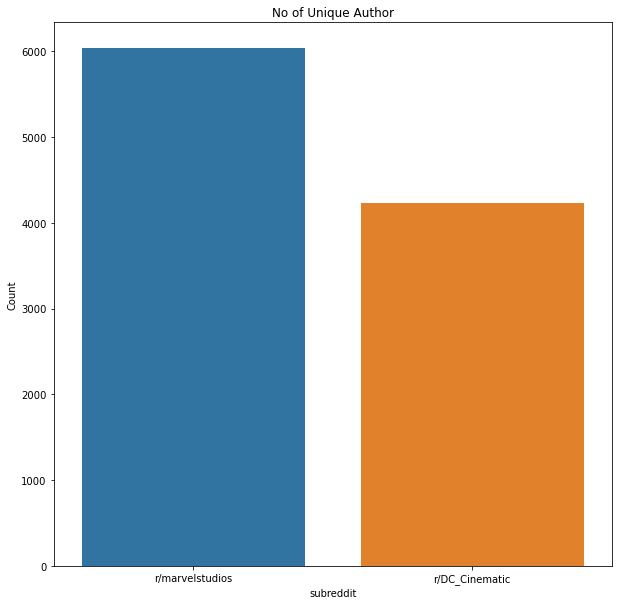

   author        subreddit
1    6035  r/marvelstudios
0    4229   r/DC_Cinematic


In [36]:
unique_author = pd.DataFrame(main_df.groupby('subreddit')['author'].nunique(),index=main_df['subreddit'].unique())
unique_author['subreddit'] = ['r/marvelstudios','r/DC_Cinematic']
plt.figure(figsize=(10,10))
plt.title('No of Unique Author')
sns.barplot(data = unique_author, x = 'subreddit',y = 'author')
plt.ylabel('Count')
plt.show();
print(unique_author)

#### 3.5.2 Word Count & Length Distribution

- The title word count for both subreddits are very similar of 11 counts
- The title length for both subreddits also shared the similar range with a length of 63~65

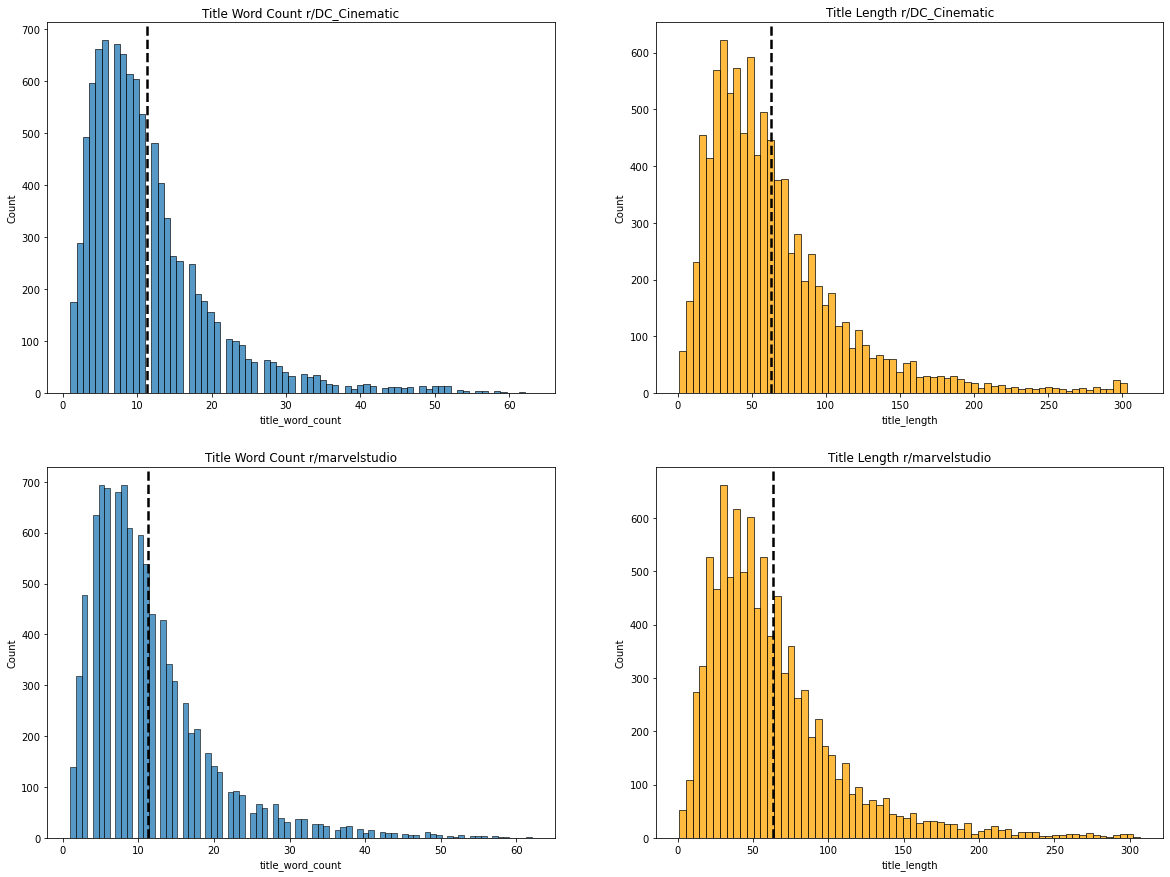

In [113]:
# Create new columns to capture word cound and length
main_df['title_word_count'] = main_df['title'].str.split().apply(len)
main_df['title_length'] = main_df['title'].apply(len)

# Mean value
title_word_count_mean_dc = main_df[main_df['subreddit']==0]['title_word_count'].mean()
title_length_mean_dc = main_df[main_df['subreddit']==0]['title_length'].mean()
title_word_count_mean_marvel = main_df[main_df['subreddit']==1]['title_word_count'].mean()
title_length_mean_marvel = main_df[main_df['subreddit']==1]['title_length'].mean()

# Display
fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].title.set_text(f"Title Word Count r/DC_Cinematic mean:{title_word_count_mean_dc}")
axs[0,1].title.set_text(f"Title Length r/DC_Cinematic mean:{title_length_mean_dc}")
axs[1,0].title.set_text(f"Title Word Count r/marvelstudios mean:{title_word_count_mean_marvel}")
axs[1,1].title.set_text(f"Title Length r/marvelstudios mean:{title_length_mean_marvel}")
sns.histplot(data= main_df[main_df['subreddit']==0],x='title_word_count', ax=axs[0,0])
sns.histplot(data= main_df[main_df['subreddit']==0],x='title_length',color='orange', ax=axs[0,1])
sns.histplot(data= main_df[main_df['subreddit']==1],x='title_word_count', ax=axs[1,0])
sns.histplot(data= main_df[main_df['subreddit']==1],x='title_length',color ='orange', ax=axs[1,1])
axs[0,0].axvline(x=title_word_count_mean_dc, c='k', ls='--', lw=2.5)
axs[0,1].axvline(x=title_length_mean_dc, c='k', ls='--', lw=2.5)
axs[1,0].axvline(x=title_word_count_mean_marvel, c='k', ls='--', lw=2.5)
axs[1,1].axvline(x=title_length_mean_marvel, c='k', ls='--', lw=2.5)
plt.show()

In [114]:
# Show mean value of title word count and length
word_count_length = [{'mean title_word_count':title_word_count_mean_dc,
                                        'mean title_length':title_length_mean_dc
                                        },
                     {'mean title_word_count':title_word_count_mean_marvel,
                                        'mean title_length':title_length_mean_marvel}]
pd.DataFrame(word_count_length,index=['r/DC_Cinematic','r/marvelstudios'])

,mean title_word_count,mean title_length
r/DC_Cinematic,11.661529,65.007551
r/marvelstudios,11.296362,63.021250


### 3.6 Feature Engineering

- Sometimes the author will include more words in the 'selftext' section which gives more context on the post itself, therefore it is merged together with the "title" feature to form a new feature called "post"

In [115]:
# Merge title and selftext
main_df['post'] = main_df['title'] + ' ' + main_df['selftext']
print(f"Number of empty post: {len(main_df.loc[main_df['post']=='',:])}")

# Drop redundant columns
main_df = main_df.drop(columns=['title','selftext'])

Number of empty post: 0


### 3.7 Tokenizing & Demojizing

- All the words are de-capitalized.

- <code>Demoji</code> function is used to convert the emoji icon into strings, so as to retain the context of the post, which will be very beneficial for sentiment analysis.

- <code>RegexpTokenizer</code> was then used to tokenize the post to remove non-latin words

- The regular expression and demoji helps to remove outliers present in the data

In [116]:
# Demojized and Tokenized data with regex
X = main_df['post']
regex_tokenizer = RegexpTokenizer('[A-Za-z]\w+')
tokens = [regex_tokenizer.tokenize(demoji.replace_with_desc(word.lower())) for word in X]

### 3.8 Stop words removal

- Additional common words that does not have much contexts were added on top of the default stopwords available in <code>nlth.corpus

In [117]:
# De-StopWord :D
stopw = stopwords.words('english')
stopw.append('removed')
stopw.append('www')
stopw.append('http')
stopw.append('https')
stopw.append('poll')
stopw.append('reddit')
stopw.append('subreddit')
stopw.append('twitter')
stopw.append('com')

print(stopw)
no_stop_words = [[word for word in token if word not in stopw] for token in tokens]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 3.9 Stemming

Running two types of stemming method:
1. <code>Porter Stemmer</code>
2. <code>Snowball Stemmer</code>

In [118]:
port_stemmer = PorterStemmer()
snow_stemmer = SnowballStemmer(language='english')
corpus_port_stemmed = []
corpus_snow_stemmed = []
corpus_unstemmed = []
corpus_demojized_only = []

# Append words into different list based on different preprocess
for word in no_stop_words:
    corpus_port_stemmed.append(" ".join([port_stemmer.stem(item) for item in word]))
    corpus_snow_stemmed.append(" ".join([snow_stemmer.stem(item) for item in word]))
    corpus_unstemmed.append(" ".join([item for item in word]))
for token in tokens:
    corpus_demojized_only.append(" ".join([item for item in token]))


In [119]:
    
# Create new column to compare before and after stemmed words
main_df['post_port_stemmed'] = pd.DataFrame(corpus_port_stemmed)
main_df['post_snow_stemmed'] = pd.DataFrame(corpus_snow_stemmed)
main_df['post_unstemmed'] = pd.DataFrame(corpus_unstemmed)
main_df['post_demojized_only'] = pd.DataFrame(corpus_demojized_only)

### 3.10 Check cleaned data

#### 3.10.1 Result of Demoji

- Emoji was succesfully converted to string text

In [120]:
# Emoji sentiment retained
main_df.sort_values('post',ascending=False).head(5)

,subreddit,num_comments,created_utc,author,title_word_count,title_length,post,post_port_stemmed,post_snow_stemmed,post_unstemmed,post_demojized_only
18719,0,10,1645822994,_pixel_perfect_,1,4,🧜‍♂️,merman,merman,merman,merman
17216,0,0,1646757986,mes05,1,1,🧐,face monocl,face monocl,face monocle,face with monocle
12220,0,0,1651641585,ConfusionNo4269,1,6,🦸🏻‍♂️🐐,man superhero light skin tone goat,man superhero light skin tone goat,man superhero light skin tone goat,man superhero light skin tone goat
14733,0,0,1648752406,ConfusionNo4269,1,2,🦇📸,bat camera flash,bat camera flash,bat camera flash,bat camera with flash
12523,0,0,1651257559,ConfusionNo4269,1,2,🦇🐐,bat goat,bat goat,bat goat,bat goat


#### 3.10.2 Empty post after preprocessing

- After stemming and stop word removal, it resulted in having some post without any strings. These post are then removed.

In [121]:
# Check for amount of empty post after preprocesssing
print(f"Number of empty porter stemmed post in subreddit DC (before): {main_df.loc[(main_df['post_port_stemmed']=='')& (main_df['subreddit']==0),:].shape[0]}")
print(f"Number of empty porter stemmed post in subreddit Marvel (before): {main_df.loc[(main_df['post_port_stemmed']=='')& (main_df['subreddit']==1),:].shape[0]}\n")
print(f"Number of empty snowball stemmed post in subreddit DC (before): {main_df.loc[(main_df['post_snow_stemmed']=='')& (main_df['subreddit']==0),:].shape[0]}")
print(f"Number of empty snowball stemmed post in subreddit Marvel (before): {main_df.loc[(main_df['post_snow_stemmed']=='')& (main_df['subreddit']==1),:].shape[0]}\n")

Number of empty porter stemmed post in subreddit DC (before): 35
Number of empty porter stemmed post in subreddit Marvel (before): 38

Number of empty snowball stemmed post in subreddit DC (before): 35
Number of empty snowball stemmed post in subreddit Marvel (before): 38



In [122]:
# Drop columns with blank posts
main_df = main_df.drop(index=main_df.loc[(main_df['post_port_stemmed']=='') | (main_df['post_snow_stemmed']==''),:].index)
print(f"Number of empty porter stemmed post (after): {main_df[main_df['post_port_stemmed']==''].shape[0]}")
print(f"Number of empty snowball stemmed post (after): {main_df[main_df['post_snow_stemmed']==''].shape[0]}")
print(f"Subreddit value count after dropping blank post: \n{main_df['subreddit'].value_counts()}\n")

Number of empty porter stemmed post (after): 0
Number of empty snowball stemmed post (after): 0
Subreddit value count after dropping blank post: 
0    9632
1    9609
Name: subreddit, dtype: int64



## 4.0 Post-Cleaning EDA

---

- Bi-grams gave a better representative of the top topic discussed in each subreddit

- The result from top common words found in the subreddit post, I was able to identify meaningful words and sentence. The top words/sentences shows the name of the superheroes.

- The common words reflects the recent new movies that was launched indicating there are a lot of recent post and the subreddit is active.


In [123]:
# Function to show common words in different n-grams using countvectorizer
def common_word_plot(min_df,n_gram,plot_title,dataframe,feature,subreddit):
    cvec = CountVectorizer(min_df=min_df,ngram_range=(n_gram,n_gram))
    cvec_data = cvec.fit_transform(dataframe[feature])
    cvec_df = pd.DataFrame(cvec_data.todense(),columns=cvec.get_feature_names())
    cvec_df['subreddit'] = dataframe['subreddit']
    
    print(f"Shape: {cvec_df.shape}")
    plt.figure(figsize=(10,7))
    top_word = cvec_df.loc[cvec_df['subreddit']==subreddit].drop(columns='subreddit').sum().sort_values(ascending=False).head(15)
    temp_df = pd.DataFrame(top_word,columns=['count'])
    sns.barplot( x=temp_df['count'],y=temp_df.index)
    plt.title(plot_title)
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show();
    return

### 4.1 Common word in r/DC_Cinematic post

- The word <span style="color:red">*batman*</span> has a siginificant high count in the posts. This can be due to the new movie "The Batman", which was release recently. <span style="color:red">*dark knight*</span> is also a reference to batman.
- <span style="color:red">*Black Adam*</span> is an upcoming movie which just released it's trailer few weeks agon on 8th June 2022.
- <span style="color:red">*Ezra Miller*</span> was the actor for the superhero character called <span style="color:red">*Flash*</span> which has a lot of rumor circulating in the news at the moment.
- <span style="color:red">*Wonder woman*</span> is a successful DC_Cinematic film



Shape: (19241, 660)


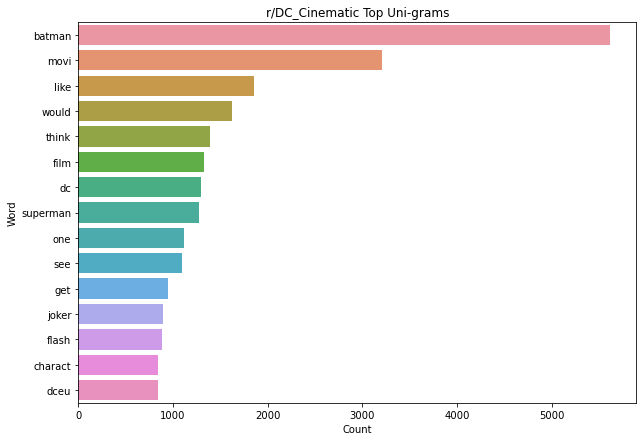

Shape: (19241, 74)


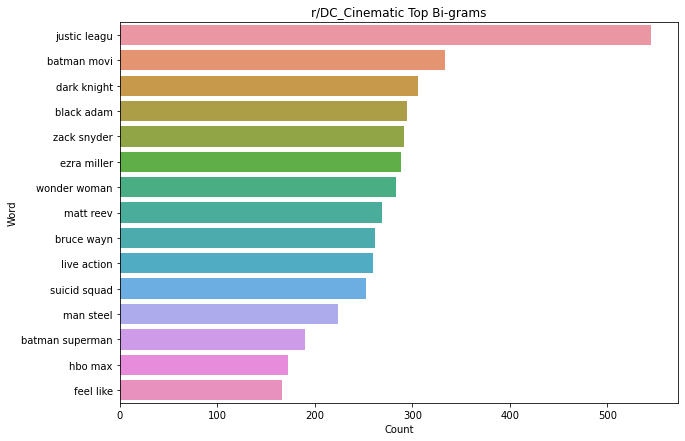

In [124]:
common_word_plot(100,1,'r/DC_Cinematic Top Uni-grams',main_df,'post_snow_stemmed',0)
common_word_plot(100,2,'r/DC_Cinematic Top Bi-grams',main_df,'post_snow_stemmed',0)

### 4.1 Common word in r/marvelstudios post

- <span style="color:red">*ms marvel*</span> is a new series that was released on 8 June 2022, which has received a lot of attention in the internet.
- <span style="color:red">*spider man, doctor strange & moon knight*</span> are recent movies and tv series.


Shape: (19241, 660)


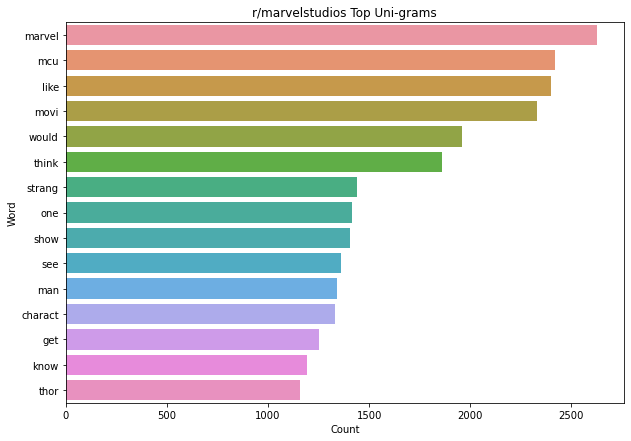

Shape: (19241, 74)


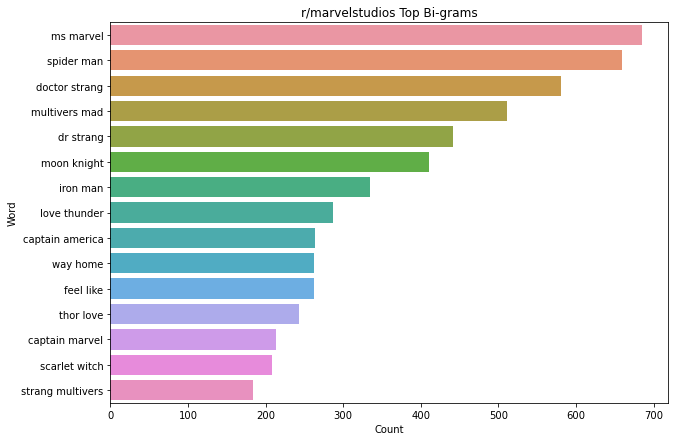

In [125]:
common_word_plot(100,1,'r/marvelstudios Top Uni-grams',main_df,'post_snow_stemmed',1)
common_word_plot(100,2,'r/marvelstudios Top Bi-grams',main_df,'post_snow_stemmed',1)

- The top uni-gram and bi-gram were able to pickup important features that are related to the r/DC_Cinematic & r/marvelstudios, which is a good data to train a classification model for these two subreddit.

- Bi-grams was shown to have a better results to read the name of the superhero character. This is because most of the characters are more than a word

## 5.0 Save Data

In [ ]:
pd.DataFrame.to_csv(main_df,'./data/main_data.csv',index_label='index')

In [ ]:
main_df.shape

---

# End of Book 2

The next book will continue with vectorization of the posts and modelling.